## $q$ Value calculations in breast cancer set

This notebook can be run locally or on a remote cloud computer by clicking the badge below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/statisticalbiotechnology/cb2030/master?filepath=nb%2Fmultiplehypo%2Fqvalue.ipynb)

### Differential expression analysis

This notebook continues from where the previous notebook on [hypothesis testing](../testing/readme) ended.

We would like to compare so called tripple negative cancers with other cancers. A breast cancer is triple negative when it does not express either [Progesterone receptors](https://en.wikipedia.org/wiki/Progesterone_receptor), [Estrogen receptors](https://en.wikipedia.org/wiki/Estrogen_receptor) or [Epidermal growth factor receptor 2](https://en.wikipedia.org/wiki/HER2/neu). Such cancers are known to behave different than other cancers, and are not amendable to regular [hormonal theraphies](https://en.wikipedia.org/wiki/Hormonal_therapy_(oncology)) in the TCGA breast cancer data set.

We first recreate the steps of the previous notebook.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
import sys
sys.path.append("..") # Read loacal modules for tcga access and qvalue calculations
import tcga_read as tcga
import qvalue

brca = tcga.get_expression_data("../../data/brca.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
brca_clin = tcga.get_clinical_data("../../data/brca_clin.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)
brca_clin.loc["3N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative") & (brca_clin.loc["IHC-HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)
def get_significance_two_groups(row):
    log_fold_change = row[tripple_negative_bool].mean() - row[~tripple_negative_bool].mean() # Calculate the log Fold Change
    p = ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1] # Calculate the significance
    return [p,-np.log10(p),log_fold_change]

pvalues = brca.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)


When plotting the $p$ value distribution below, we see an enrichment of low p values. These are the tests of the genes that adhere to the alternative hypothesis. We also see a uniform distribution of the $p$ values in the higher end of the distribution i.e. $p$ values of 0.3-1.0. These are likely steming from genes adhering to $H_0$

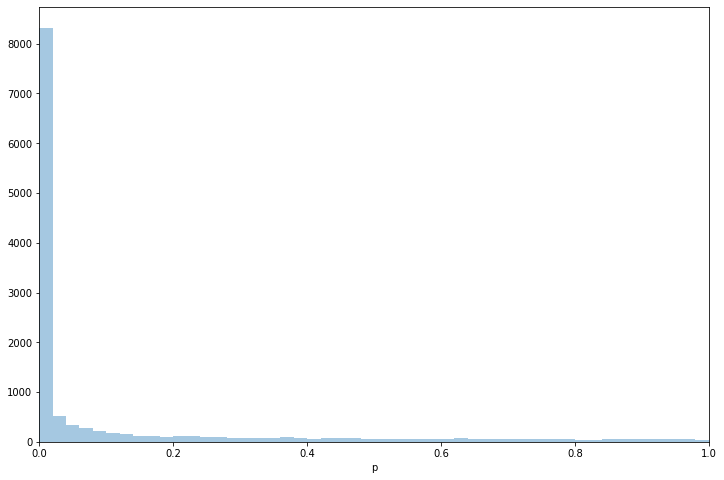

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.distplot(pvalues["p"],kde=False)
plt.xlim(0,1.0);

### $q$ value esitmation
We define a function for the palculation of $\pi_0$. Here we use a different method than the one described in Storey&Tibshirani. The details of this method, known as the *bootstrap method*, are given in [Storey 2002](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9868.00346)

In [3]:
import numpy as np
import numpy.random as npr

def bootstrap(invec):
    idx = npr.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]

def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    p.sort()
    n=len(p)
    lambdas=np.linspace(maxLambda/numLambda,maxLambda,numLambda)
    Wls=np.array([n-np.argmax(p>=l) for l in lambdas])
    pi0s=np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0=np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])
        pi0sBoot =np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]

We subsequently use Storey&Tibshirani to calculate first calculate 
$$ 
\hat{\rm FDR}(t) = \frac{\pi_0mp}{|\{p_i\le t\}|}
$$
and then smooth the $\rm FDR(t)$ estimates as $$\hat{q}(p_i)=min_{t \ge p_i}\hat{\rm FDR}(t)$$

In [4]:
def qvalues(pvalues):
    m = pvalues.shape[0] # The number of p-values
    pvalues.sort_values("p",inplace=True) # sort the pvalues in acending order
    pi0 = estimatePi0(list(pvalues["p"].values))
    print("pi_0 estimated to " + str(pi0))
    
    # calculate a FDR(t) as in Storey & Tibshirani
    num_p = 0.0
    for ix in pvalues.index:
        num_p += 1.0
        t = pvalues.loc[ix,"p"]
        fdr = pi0*t*m/num_p
        pvalues.loc[ix,"q"] = fdr
        pi0_hat = (m-num_p)/(m*(1-t))
        pvalues.loc[ix,"pi0_hat"] = pi0_hat
    
    # calculate a q(p) as the minimal FDR(t)
    old_q=1.0
    for ix in reversed(list(pvalues.index)):
        q = min(old_q,pvalues.loc[ix,"q"])
        old_q = q
        pvalues.loc[ix,"q"] = q
    return pvalues

In [5]:
qv = qvalues(pvalues)

pi_0 estimated to 0.193835872948997


We note a very low $\pi_0$ indicating that about 80\% of all genes are differentially expressed in the tripple negative cancers. This is maybe not only reflects the different biology of tripple negative cancers, but might also relate to differencees in sample handlig or normalization of data.

A plot of the number of differentially expressed genes as a function of $q$ value gives the same message.

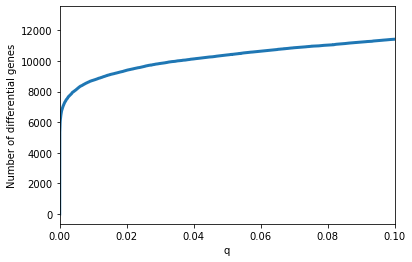

In [6]:
sns.lineplot(pvalues["q"],list(range(pvalues.shape[0])),ci=None,lw=3)
plt.xlim(0,0.1);
plt.ylim();
plt.ylabel("Number of differential genes");

We can list the differntial genes, in descending order of significance.

In [7]:
qv

,p,-log_p,log_FC,q,pi0_hat
Hugo_Symbol,,,,,
NAT1,3.104964e-45,44.507943,-3.919466,7.780762e-42,0.999923
TBC1D9,2.162932e-43,42.664957,-3.116726,2.475169e-40,0.999845
ESR1,2.963198e-43,42.528239,-5.855994,2.475169e-40,0.999768
ARMT1,5.785445e-43,42.237663,-1.932617,3.624451e-40,0.999691
SLC16A6,7.397218e-43,42.130932,-3.157309,3.707353e-40,0.999613
...,...,...,...,...,...
SCRN1,9.989525e-01,0.000455,-0.000178,1.936928e-01,0.295374
GPKOW,9.990908e-01,0.000395,0.000066,1.936928e-01,0.255238
FUT10,9.991074e-01,0.000388,-0.000106,1.936928e-01,0.173317


We can now show a FDR of $10^{-10}$ in our previously calculated Volcano Plot.

In [8]:
qv["Significant"] = qv["q"]<1e-10
less_than_FDR_10 = qv[qv["q"]<1e-10]
p_treshold = float(less_than_FDR_10.iloc[-1:]["-log_p"].values)

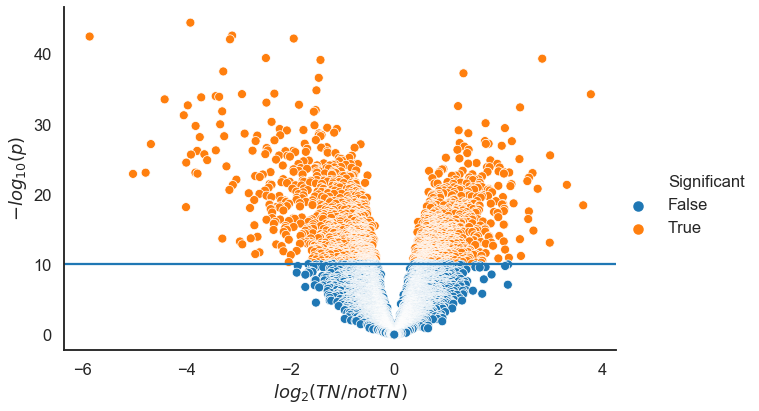

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")
ax = sns.relplot(data=pvalues,x="log_FC",y="-log_p",hue="Significant",aspect=1.5,height=6)
plt.axhline(p_treshold)
#sns.lineplot([-6,4],[p_treshold,p_treshold],ax=ax)
ax.set(xlabel="$log_2(TN/not TN)$", ylabel="$-log_{10}(p)$");

## Spline estimation of $\pi_0$ (Requested by student)

Storey and Tibshirani outlines an other procedure for estimating $\pi_0$ as 
$$\hat{\pi_0}(\lambda) = \frac{|\{p>\lambda \}|}{m(1-\lambda)}$$.

We do almost what the article prescribes (please try to find the difference on how we select which lambdas we evaluate). Furthermore we fit a [qubic spline](https://en.wikipedia.org/wiki/Smoothing_spline) to these $\pi_0$ estimates.


In [10]:
from scipy.interpolate import UnivariateSpline

m = pvalues.shape[0] # The number of p-values
pvalues.sort_values("p",inplace=True,ascending=False) # sort the pvalues in decending order
num_p = -1
for ix in pvalues.index:
    num_p += 1
    lambda_p = pvalues.loc[ix,"p"]
    pi0_hat = num_p/(m*(1-lambda_p))
    pvalues.loc[ix,"pi0_hat"] = pi0_hat

pvalues.sort_values("p",inplace=True) # sort the pvalues in ascending order
s = UnivariateSpline(pvalues["p"],pvalues["pi0_hat"], k=3,s=10)


We plot the estimates (blue) as well as the spline fit (red) for two different intevalls of $\lambda$. You will see the need of a smoother, particularly in the region near 1.0.

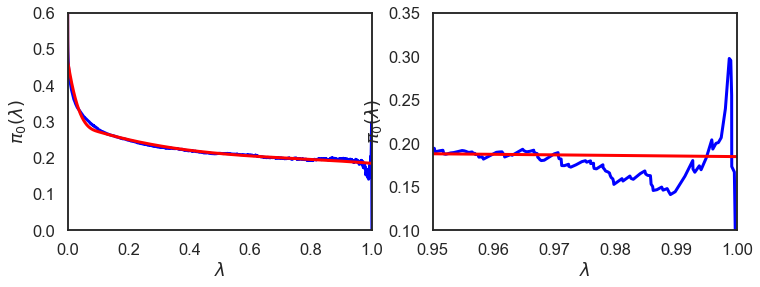

In [11]:
def plot_pi0_hat(p,s,xlow,xhigh,ylow,yhigh,ax):
  sns.lineplot(pvalues["p"],pvalues["pi0_hat"],ci=None,lw=3, ax=ax, color='b')
  sns.lineplot(pvalues["p"],s(pvalues["p"]),ci=None,lw=3,ax=ax, color='r')
  ax.set_xlim(xlow,xhigh);
  ax.set_ylim(ylow,yhigh);
  ax.set_xlabel("$\lambda $");
  ax.set_ylabel("$\pi_0(\lambda)$");

fig, ax = plt.subplots(1,2,figsize=(12, 4))
plot_pi0_hat(pvalues,s,0,1,0,0.6,ax[0])
plot_pi0_hat(pvalues,s,0.95,1,0.1,0.35,ax[1])


We can obtain a final estimate by evaluating the spline for $\lambda=1$, and compare the it to the bootstrapping estimate. 

In [12]:
print("Spline estimate of pi_0: " + str(s(1)))
print("Bootstrap estimate of pi_0: " + str(estimatePi0(list(pvalues["p"].values))))

Spline estimate of pi_0: 0.18471621734494037
Bootstrap estimate of pi_0: 0.193835872948997
